E:\_SoftEng\_BeCode\real-estate-price-predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[I 2025-06-28 23:25:02,273] A new study created in memory with name: no-name-710592ba-dbb2-4173-8bdc-daeeeb936fc1


[I 2025-06-28 23:25:10,645] Trial 0 finished with value: 98990.35147272234 and parameters: {'max_depth': 9, 'learning_rate': 0.2222085211721762, 'n_estimators': 426, 'subsample': 0.8238370533961206, 'colsample_bytree': 0.5778607991982954, 'reg_alpha': 0.39944683347398324, 'reg_lambda': 0.211591821075794, 'min_child_weight': 2.454470668213156, 'gamma': 4.432386132640234}. Best is trial 0 with value: 98990.35147272234.


[I 2025-06-28 23:25:12,414] Trial 1 finished with value: 97009.91210903127 and parameters: {'max_depth': 4, 'learning_rate': 0.212757499022449, 'n_estimators': 194, 'subsample': 0.9006930931537334, 'colsample_bytree': 0.6424844700339698, 'reg_alpha': 0.24192361183350652, 'reg_lambda': 0.48828615514959295, 'min_child_weight': 2.766745206148411, 'gamma': 2.9837727004652863}. Best is trial 1 with value: 97009.91210903127.


[I 2025-06-28 23:25:15,759] Trial 2 finished with value: 101170.66760562286 and parameters: {'max_depth': 6, 'learning_rate': 0.2932255010355535, 'n_estimators': 280, 'subsample': 0.5853947083898636, 'colsample_bytree': 0.5525932246780898, 'reg_alpha': 0.8286965215079122, 'reg_lambda': 0.8305525280036088, 'min_child_weight': 5.975274182114773, 'gamma': 0.055272955531449064}. Best is trial 1 with value: 97009.91210903127.


[I 2025-06-28 23:25:16,116] A new study created in memory with name: no-name-403f6de0-bb71-4756-886e-bc7021b1cc41


[I 2025-06-28 23:25:18,524] Trial 0 finished with value: 97465.49738248489 and parameters: {'max_depth': 7, 'learning_rate': 0.18211937680505896, 'n_estimators': 185, 'subsample': 0.8487972173290879, 'colsample_bytree': 0.988698072406115, 'reg_alpha': 0.06728139535202615, 'reg_lambda': 0.819757675859222, 'min_child_weight': 5.668228397541663, 'gamma': 2.440314425853805}. Best is trial 0 with value: 97465.49738248489.


[I 2025-06-28 23:25:29,007] Trial 1 finished with value: 99332.92477091204 and parameters: {'max_depth': 8, 'learning_rate': 0.19631936806653993, 'n_estimators': 720, 'subsample': 0.9339840740998897, 'colsample_bytree': 0.635793040324759, 'reg_alpha': 0.956490942186234, 'reg_lambda': 0.10764583006914452, 'min_child_weight': 5.771259595099346, 'gamma': 0.8166600091846521}. Best is trial 0 with value: 97465.49738248489.


[I 2025-06-28 23:25:33,338] Trial 2 finished with value: 94922.49814839859 and parameters: {'max_depth': 7, 'learning_rate': 0.04486614523778114, 'n_estimators': 340, 'subsample': 0.7488155040947846, 'colsample_bytree': 0.7279426411571861, 'reg_alpha': 0.27350382471737367, 'reg_lambda': 0.29073313195676653, 'min_child_weight': 6.424553076099616, 'gamma': 3.026944013173684}. Best is trial 2 with value: 94922.49814839859.


Evaluation – XGBoost + Optuna CV (All Features)
  MAE:  57,331.57 €
  RMSE: 82,338.95 €
  R²:   0.8447
----------------------------------------
Evaluation – XGBoost + Optuna CV (Top RF Features)
  MAE:  48,709.38 €
  RMSE: 69,322.48 €
  R²:   0.8899
----------------------------------------
[✓] Model evaluation for 'XGBoost + Optuna CV (All Features)' logged.
[✓] Model evaluation for 'XGBoost + Optuna CV (Top RF Features)' logged.
Evaluation Summary (All Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,best,type,rank_r2,rmse/mae
0,25,2025-06-28 23:24:12,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2323.csv,Linear Regression (All Features),202506282323,76 898.76 €,109 935.46 €,0.723000,,Linear,4,1.430000
1,26,2025-06-28 23:24:41,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2323.csv,Random Forest (All Features),202506282323,68 324.02 €,101 428.25 €,0.764200,,Tree,2,1.480000
2,27,2025-06-28 23:24:50,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250628_2323.csv,Random Forest (Top 10 Features),202506282323,71 734.61 €,106 140.03 €,0.741800,,Tree,3,1.480000
3,28,2025-06-28 23:25:34,XGBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2323.csv,XGBoost with Optuna (All Features),202506282323,57 331.57 €,82 338.95 €,0.844700,✓,Boosting,1,1.440000



👉 Best model based on R²: XGBoost + Optuna CV (All Features) ✓
Evaluation Summary (Top RF Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,best,type,rank_r2,rmse/mae
0,25,2025-06-28 23:24:12,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2323.csv,Linear Regression (All Features),202506282323,76 898.76 €,109 935.46 €,0.723000,,Linear,5,1.430000
1,26,2025-06-28 23:24:41,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2323.csv,Random Forest (All Features),202506282323,68 324.02 €,101 428.25 €,0.764200,,Tree,3,1.480000
2,27,2025-06-28 23:24:50,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250628_2323.csv,Random Forest (Top 10 Features),202506282323,71 734.61 €,106 140.03 €,0.741800,,Tree,4,1.480000
3,28,2025-06-28 23:25:34,XGBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2323.csv,XGBoost with Optuna (All Features),202506282323,57 331.57 €,82 338.95 €,0.844700,,Boosting,2,1.440000
4,29,2025-06-28 23:25:34,XGBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250628_2323.csv,XGBoost with Optuna (Top RF Features),202506282323,48 709.38 €,69 322.48 €,0.889900,✓,Boosting,1,1.420000



👉 Best model based on R²: XGBoost + Optuna CV (Top RF Features) ✓
Diagnostics (All Features):


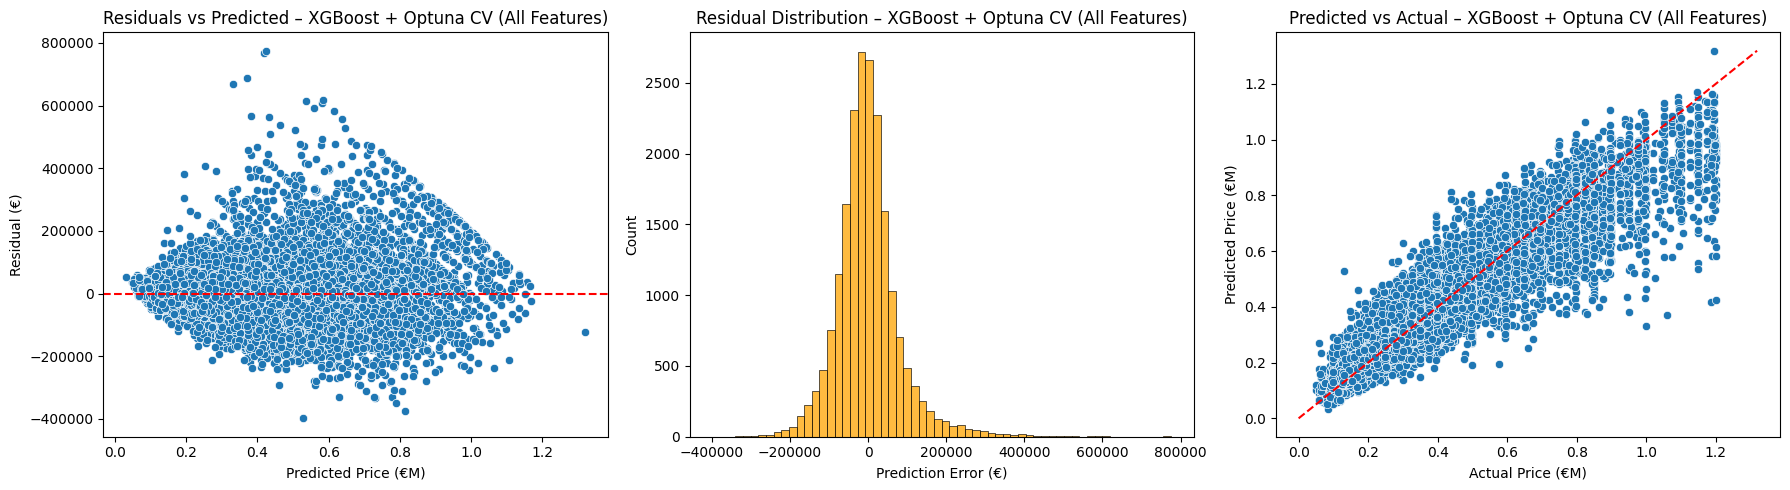

Diagnostics (Top RF Features):


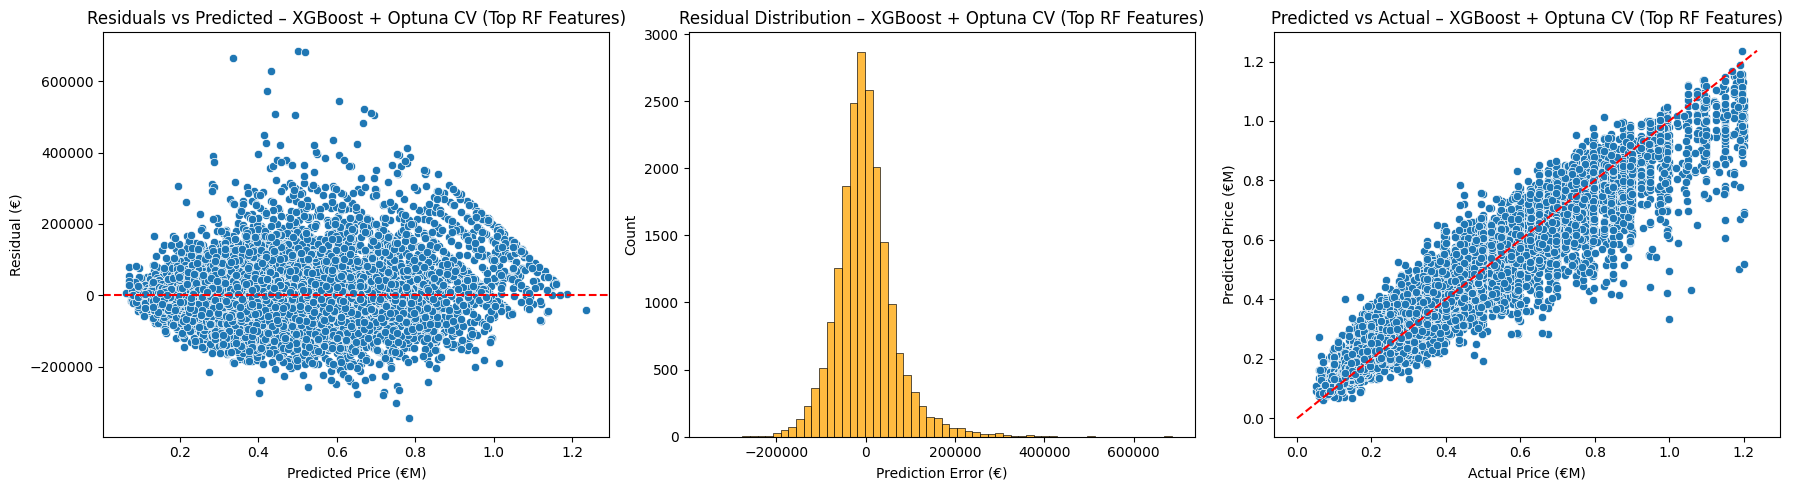

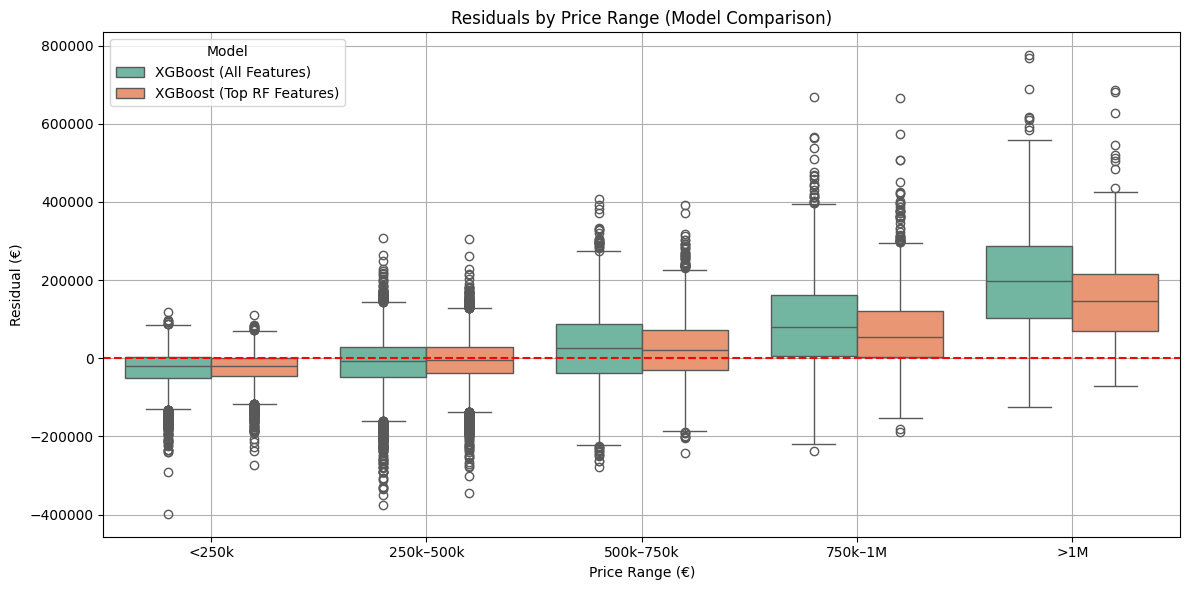

'\nModelEvaluator.plot_shap_comparison_beeswarm(\n    model_all=model_all,\n    x_all=X_reduced,\n    model_top=model_top,\n    x_top=X_top\n)\n'

In [1]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import optuna
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.experiment_tracker import ExperimentTracker
from utils.model_visualizer import ModelVisualizer

import numpy as np
import pandas as pd


# Root Mean Squared Error
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Step 1: Load and clean dataset
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()

X = df.drop(columns=["price"])
y = df["price"]

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X)  # Fit the selector on the full dataset
X_reduced = X.loc[:, selector.get_support()]

# Step 3: Extract top 30 features using Random Forest
rf_model_all = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_all.fit(X_reduced, y)

importances = rf_model_all.feature_importances_
feature_ranking = pd.Series(importances, index=X_reduced.columns).sort_values(ascending=False)
top_features = feature_ranking.head(30).index.tolist()
X_top = X_reduced[top_features]

# Step 4: Define Optuna tuning function
def tune_xgboost_with_optuna(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 100, 800),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
        }
        model = xgb.XGBRegressor(**params, objective="reg:squarederror", random_state=42, n_jobs=-1)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = -cross_val_score(model, X_data, y_data, scoring="neg_root_mean_squared_error", cv=cv)
        return scores.mean()

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study


# Step 5: Tune and train both models
n_trials = 3 if TEST_MODE else 50

study_all = tune_xgboost_with_optuna(X_reduced, y, n_trials=n_trials)
model_all = xgb.XGBRegressor(**study_all.best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
model_all.fit(X_reduced, y)
y_pred_all = model_all.predict(X_reduced)

study_top = tune_xgboost_with_optuna(X_top, y, n_trials=n_trials)
model_top = xgb.XGBRegressor(**study_top.best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
model_top.fit(X_top, y)
y_pred_top = model_top.predict(X_top)

# Step 6: Evaluate models
evaluator_all = ModelEvaluator("XGBoost + Optuna CV (All Features)")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y, y_pred_all)

evaluator_top = ModelEvaluator("XGBoost + Optuna CV (Top RF Features)")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y, y_pred_top)

# Step 7: Log results
tracker = ExperimentTracker()
df_metrics_all = tracker.log_and_get_evaluations(
    model="XGBoost + Optuna CV (All Features)",
    experiment="XGBoost with Optuna (All Features)",
    mae=mae_all,
    rmse=rmse_all,
    r2=r2_all,
)

df_metrics_top = tracker.log_and_get_evaluations(
    model="XGBoost + Optuna CV (Top RF Features)",
    experiment="XGBoost with Optuna (Top RF Features)",
    mae=mae_top,
    rmse=rmse_top,
    r2=r2_top,
)

# Step 8: Display evaluation summary
print("Evaluation Summary (All Features):")
evaluator_all.display_model_summary(df_metrics_all)

print("Evaluation Summary (Top RF Features):")
evaluator_top.display_model_summary(df_metrics_top)

# Step 9: Visual diagnostics
print("Diagnostics (All Features):")
visualizer_all = ModelVisualizer(model_all, X_reduced, y, model_name="XGBoost + Optuna CV (All Features)")
visualizer_all.plot_all_diagnostics()

print("Diagnostics (Top RF Features):")
visualizer_top = ModelVisualizer(model_top, X_top, y, model_name="XGBoost + Optuna CV (Top RF Features)")
visualizer_top.plot_all_diagnostics()


ModelEvaluator.plot_price_range_residuals_side_by_side(
    y,
    y_pred_all,
    y_pred_top,
    model_names=("XGBoost (All Features)", "XGBoost (Top RF Features)")
)

"""
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""

In [2]:
def plot_shap_comparison_beeswarm(model_all, x_all, model_top, x_top):
    import shap
    import matplotlib.pyplot as plt

    explainer_all = shap.Explainer(model_all)
    explainer_top = shap.Explainer(model_top)

    shap_values_all = explainer_all(x_all)
    shap_values_top = explainer_top(x_top)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    shap.plots.beeswarm(shap_values_all, max_display=15, show=False)
    plt.title("SHAP Summary – All Features", fontsize=13)
    

    plt.subplot(1, 2, 2)
    shap.plots.beeswarm(shap_values_top, max_display=15, show=False)
    plt.title("SHAP Summary – Top RF Features", fontsize=13)

    plt.tight_layout()
    plt.show()

"""
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""

'\nModelEvaluator.plot_shap_comparison_beeswarm(\n    model_all=model_all,\n    x_all=X_reduced,\n    model_top=model_top,\n    x_top=X_top\n)\n'